# Concurrent Programming

Concurrent programming is where several tasks are executed during *overlapping* time periods (concurrently) instead of sequentially (complete one task before the next one starts).

Concurrent processes can be executed on one processor by interleaving the execution steps of each process via time-sharing slices: only one process runs at a time, and if it does not complete during its time slice, it is paused, another process begins or resumes, and then later the original process is resumed. Multiple processes are partially complete at any point in time, but only *one* process is running at any instant.

Not to be confused with parallelism, concurrency is when multiple operations are run in overlapping periods, while parallelism executes these operations simultaneously. 

## Transferring Cash Example

We illustrate this example with a bank server that maintains accounts and balances. There are ATMs worldwide that connect to the server and make transaction requests corresponding to deposits, withdrawals and transfers.

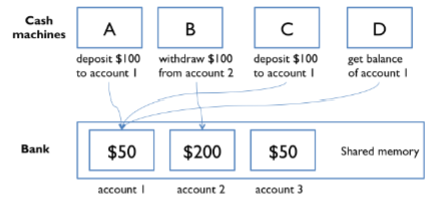

e.g. When`A=0` and `B=1000`. Suppose `T1` want so transfer `500` from `B` to `A` and `T2` wants to transfer `200` from `B` to `A`. Then, the code executes like:

```
A = 0 
B = 1000 
 
T1: newA = 0 + 500 
 
#T2 starts executing in the middle of T1's run!
T2: newA = 0 + 200 
T2  newB = 1000 - 200 = 800 
T2: A = 200
T2: B = 800 
 
T1: newB = 800 - 500 = 300 
T1: A = newA = 500 
T1: B = newB = 300
```

Because `A` and `B` are global variables instead of local, and the different computations start in the middle of each other, this causes incorrect results.

In [1]:
from threading import *
import time
from random import random

In [8]:
## Version 1

A = 0
B = 1000

def transfer(amt):
    global A, B
    newA = A + amt
    time.sleep(0.1)
    newB = B - amt
    A = newA
    B = newB
    
    toprint = "total = " + str(newA + newB) + "    A = " + str(newA) + " B = " + str(newB)
    print(toprint)


start = time.time()    
def fun1():
    #how long to run code for
    while time.time() - start < 10:
        transfer(int(100 * random() - 50))

x = Thread(target=fun1)
y = Thread(target=fun1)

x.start()
y.start()


### Races and Locks

A  **race  condition**  or  race  means  that  the  correctness  of  the  program  (the 
satisfaction  of  postconditions  and  invariants)  depends  on  the  relative  timing of 
events in concurrent computations X and Y. When this happens, we say “X is in a 
race with Y.” Threads T1 and T2 are racing to read and/or write global variables. If 
one of them allowed the other to start and finish, we would not have this issue.

We can remove a race condition using the principle of *mutual exclusion*, which assures only one process can handle the shared resource at a time, while other processes wait. We can allow exclusive access through the use of locks.

`lock.acquire()` and `lock.release()` ensure that at most one thread in this section of code modifies the global variables. When one thread enters this chunk, the other threads need to wait.

> interestingly enough, when you use `Run All` the locked version will still have errors, despite using completely different variable and function names and still accessing global variables `A,B`. When I wait for one cell to complete before running the next, I get no errors.

In [9]:
## Version 3

A = 0
B = 1000

lock = Lock()
def lockedtransfer(amt):
    lock.acquire()
    global A, B
    newA = A + amt
    time.sleep(0.1)
    newB = B - amt
    A = newA
    B = newB
    
    toprint = "LOCKED total = " + str(newA + newB) + " A = " + str(newA) + " B = " + str(newB)
    print(toprint)

    lock.release()



start = time.time()    
def fun1_locked():
    while time.time() - start < 10:
        lockedtransfer(int(100 * random() - 50))

x_locked = Thread(target=fun1_locked)
y_locked = Thread(target=fun1_locked)

x_locked.start()
y_locked.start()


## Dining Philosophers Example

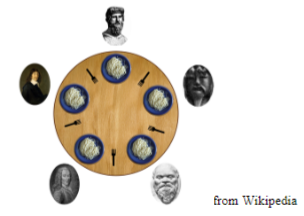

5 philosophers sit at a round table, with forked placed between each pair of adjacent philosophers. Each philosopher must alternately think and eat. However, a philosopher can only eat when they have both left and right forks. Only one philosopher can use a fork at one time. The problem is how to design a concurrent algorithim to ensure each philosopher can forever alternate between eating and thinking.

### A Simple Strategy

- Think until the left fork is available; when it is, pick it up
- Think until the right fork is available; when it is, pick it up
- When both forks are held, eat for finite time.
- Put right fork down
- Put left fork down
- Repeat

We number the philosophers `0` till `4`, and also number the forks `0` till `4`, with fork `i` to the left of philosopher `i`. The fork to the right of philosopher is hence `(i+1)%5`

In [1]:
import sys
import time
from random import random
from threading import Thread, Event, Lock

def safePrint(content):
    sys.stdout.write("{0}\n".format(content))
    sys.stdout.flush()

print = safePrint  # override the default print

In [14]:
N = 5
forks = [1] * N
stop_event = Event()

def pickupFork(philosopher, forkPosition):
    if forks[forkPosition] == 1:  # there is a fork at this position
        time.sleep(random() * 0.5)  # it takes some time to pick up the fork
        forks[forkPosition] -= 1  # update to not available ONLY IF SUCCESSFUL PICKING IT UP
        return True
    print(f"Philosopher {philosopher} cannot acquire fork {forkPosition}")
    return False

def tryEat(philosopher):
    firstFork = philosopher  # left fork's position
    secondFork = (philosopher + 1) % N  # right fork's position
    if pickupFork(philosopher, firstFork):
        if pickupFork(philosopher, secondFork):
            print(f'Philosopher {philosopher} enjoys the food with forks {firstFork} and {secondFork}')
            time.sleep(5)  # eating for a long time
            putBackFork(secondFork)  # update back to available
            putBackFork(firstFork)   # update back to available
        else:
            putBackFork(firstFork)  # return left fork back;we successfully pick up left but not right

def putBackFork(forkPosition):
    forks[forkPosition] += 1

def philosopher_action(philosopher):
    #as long as stop_event is still False
    while not stop_event.is_set():
        tryEat(philosopher)
        time.sleep(random() * 2)  # thinking time

def check_forks():
    #run as long as stop_event still False
    while not stop_event.is_set():
        time.sleep(N * 0.5 + 2)  # wait before checking forks
        for forkPosition in range(N):
            if forks[forkPosition] < 0:
                print(f"Two philosophers are trying to eat with the same fork {forkPosition} (yuck)!")
        time.sleep(5)  # wait after checking forks

start = time.time()
runtime = 5 # demonstrates for 5 seconds

# Start philosopher threads
threadPool = [Thread(target=philosopher_action, args=(i,)) for i in range(N)]
for thread in threadPool:
    thread.start()

# Start fork checking thread
fork_check_thread = Thread(target=check_forks)
fork_check_thread.start()

# Main thread: wait for runtime to elapse
while time.time() - start < runtime:
    time.sleep(1)

# Makes it such that philosopher_action terminates
stop_event.set()

# # Wait for all threads to finish
# for thread in threadPool:
#     thread.join()
# fork_check_thread.join()

print("\nTime's up! Simulation ended.")

Philosopher 4 cannot acquire fork 0
Philosopher 0 enjoys the food with forks 0 and 1
Philosopher 2 enjoys the food with forks 2 and 3
Philosopher 1 cannot acquire fork 2
Philosopher 3 enjoys the food with forks 3 and 4
Philosopher 4 cannot acquire fork 0
Philosopher 4 cannot acquire fork 4
Philosopher 1 cannot acquire fork 1
Philosopher 1 cannot acquire fork 1
Philosopher 4 cannot acquire fork 4
Philosopher 4 cannot acquire fork 4
Philosopher 4 cannot acquire fork 4
Philosopher 1 cannot acquire fork 1
Two philosophers are trying to eat with the same fork 3 (yuck)!
Philosopher 4 cannot acquire fork 4
Philosopher 1 cannot acquire fork 1
Philosopher 4 cannot acquire fork 4
Philosopher 4 cannot acquire fork 4

Time's up! Simulation ended.


Philosopher 2 is starving!


### Adding Locks to Dining Philosophers

This attempted solution fails because it allows the system to reach a **deadlock** state, 
in which no progress is possible. This is a state in which each philosopher has 
picked up the fork to the left, and is waiting for the fork to the right to become 
available. With the given instructions, this state can be reached, and when it is 
reached, the philosophers will eternally wait for each other to release a fork.

> the below code enters deadlock where all locks are acquired and are never released lol
>
> That's why a `timeout` to the `acquire` function is needed

> The state_lock is so we can access the status safely

In [2]:
N = 5
forks = [1] * N
stop_event = Event()
forkLocks = [Lock() for _ in range(N)]

philosopher_states = ['thinking'] * N
state_lock = Lock()

def tryReleaseLock(lock):
    try:
        lock.release()
    except RuntimeError:
        print('thread error!') # the monitor might detect a deadlock and release my lock.

def pickupFork(philosopher, forkPosition):
    
    print(f"Philosopher {philosopher} trying to pick up fork {forkPosition}")
    forkLocks[forkPosition].acquire(timeout=lock_timeout)
    if forks[forkPosition] == 1:
        time.sleep(random() * 0.5)
        forks[forkPosition] -= 1
        print(f"Philosopher {philosopher} picked up fork {forkPosition}")
        
        #hold onto this lock if ive picked it up

        return True
    print(f"Philosopher {philosopher} cannot acquire fork {forkPosition}")

    #if ive failed, then release the lock
    tryReleaseLock(forkLocks[forkPosition])
    return False

def tryEat(philosopher):
    firstFork = philosopher
    secondFork = (philosopher + 1) % N

    with state_lock:
        philosopher_states[philosopher] = 'waiting for left fork'
    
    if pickupFork(philosopher, firstFork):
        with state_lock:
            philosopher_states[philosopher] = 'waiting for right fork'
        
        #if the lock isnt released, the below pickupFork cannot even execute fully to return False
        if pickupFork(philosopher, secondFork):
            with state_lock:
                philosopher_states[philosopher] = 'eating'
            print(f'Philosopher {philosopher} enjoys the food with forks {firstFork} and {secondFork}')
            time.sleep(5)
            putBackFork(secondFork)
            putBackFork(firstFork)
        else:
            putBackFork(firstFork)
            print(f'Philosopher {philosopher} cant access second fork')
    else:
        print(f'Philosopher {philosopher} cant even access the first fork!')
    
    with state_lock:
        philosopher_states[philosopher] = 'thinking'

def putBackFork(forkPosition):
    forks[forkPosition] += 1
    #release the lock when i put it back
    tryReleaseLock(forkLocks[forkPosition])

def philosopher_action(philosopher):
    while not stop_event.is_set():
        tryEat(philosopher)
        time.sleep(random() * 2)

def check_deadlock():
    while not stop_event.is_set():
        with state_lock:
            if all(state == 'waiting for right fork' for state in philosopher_states):
                print("DEADLOCK DETECTED: All philosophers are waiting for their right forks!")
        time.sleep(1)

def check_forks():
    while not stop_event.is_set():
        time.sleep(N * 0.5 + 2)
        for forkPosition in range(N):
            if forks[forkPosition] < 0:
                print(f"Two philosophers are trying to eat with the same fork {forkPosition} (yuck)!")
        time.sleep(5)

start = time.time()
runtime = 7
#this is IMPORTANT
lock_timeout=3*runtime

threadPool = [Thread(target=philosopher_action, args=(i,)) for i in range(N)]
for thread in threadPool:
    thread.start()

fork_check_thread = Thread(target=check_forks)
fork_check_thread.start()

deadlock_check_thread = Thread(target=check_deadlock)
deadlock_check_thread.start()

while time.time() - start < runtime:
    time.sleep(1)

stop_event.set()

for thread in threadPool:
    thread.join()
fork_check_thread.join()
deadlock_check_thread.join()

print("\nTime's up! Simulation ended.")

Philosopher 0 trying to pick up fork 0
Philosopher 1 trying to pick up fork 1
Philosopher 2 trying to pick up fork 2
Philosopher 3 trying to pick up fork 3
Philosopher 4 trying to pick up fork 4
Philosopher 4 picked up fork 4
Philosopher 4 trying to pick up fork 0
Philosopher 1 picked up fork 1
Philosopher 1 trying to pick up fork 2
Philosopher 2 picked up fork 2
Philosopher 2 trying to pick up fork 3
Philosopher 0 picked up fork 0
Philosopher 0 trying to pick up fork 1
Philosopher 3 picked up fork 3
Philosopher 3 trying to pick up fork 4
DEADLOCK DETECTED: All philosophers are waiting for their right forks!
DEADLOCK DETECTED: All philosophers are waiting for their right forks!
DEADLOCK DETECTED: All philosophers are waiting for their right forks!
DEADLOCK DETECTED: All philosophers are waiting for their right forks!
DEADLOCK DETECTED: All philosophers are waiting for their right forks!
DEADLOCK DETECTED: All philosophers are waiting for their right forks!
DEADLOCK DETECTED: All philos

### Dijkstra's Ordering Solution

This solution developed by Dijkstra assigns an order to resources and ensure we only consume resources in a specific order.

- Assign a unique number to each fork (resource), from `0` to `n-1`
  - This forms some sort of global ordering
  - One way is to only request forks in **ascending** order of their forks
  - e.g. philosopher `2` must request the lower order right fork `2` before the higher order left fork `3`
- The order in which forks are released doesn't matter

This prevents deadlock: philosophers `0,1,2,3` will pick up the left lower-ordered fork first. Philosopher `4` must pick up the lower order right fork `0`, but it is used - hence we don't enter a deadlock where each philosopher picks up their left fork. There's at least one fork left on the table at any point.

> note that this doesn't resolve the fairness issue: no way of ensuring each philosopher get to eat with roughly same amount of time

In [4]:
N = 5
forks = [1] * N
stop_event = Event()
forkLocks = [Lock() for _ in range(N)]

philosopher_states = ['thinking'] * N
state_lock = Lock()

def tryReleaseLock(lock):
    try:
        lock.release()
    except RuntimeError:
        print('thread error!') # the monitor might detect a deadlock and release my lock.

def pickupFork(philosopher, forkPosition):
    
    print(f"Philosopher {philosopher} trying to pick up fork {forkPosition}")
    forkLocks[forkPosition].acquire(timeout=lock_timeout)
    if forks[forkPosition] == 1:
        time.sleep(random() * 0.5)
        forks[forkPosition] -= 1
        print(f"Philosopher {philosopher} picked up fork {forkPosition}")
        
        #hold onto this lock if ive picked it up

        return True
    print(f"Philosopher {philosopher} cannot acquire fork {forkPosition}")

    #if ive failed, then release the lock
    tryReleaseLock(forkLocks[forkPosition])
    return False

def tryEat(philosopher):
    firstFork = philosopher
    secondFork = (philosopher + 1) % N

    with state_lock:
        philosopher_states[philosopher] = 'waiting for left fork'

        # ---------------- Difference ---------------
    if(firstFork > secondFork):
        firstFork, secondFork = secondFork, firstFork # always fetch the smallest first
    # -------------------------------------------
    
    if pickupFork(philosopher, firstFork):
        with state_lock:
            philosopher_states[philosopher] = 'waiting for right fork'
        
        #if the lock isnt released, the below pickupFork cannot even execute fully to return False
        if pickupFork(philosopher, secondFork):
            with state_lock:
                philosopher_states[philosopher] = 'eating'
            print(f'Philosopher {philosopher} enjoys the food with forks {firstFork} and {secondFork}')
            time.sleep(5)
            putBackFork(secondFork)
            putBackFork(firstFork)
        else:
            putBackFork(firstFork)
            print(f'Philosopher {philosopher} cant access second fork')
    else:
        print(f'Philosopher {philosopher} cant even access the first fork!')
    
    with state_lock:
        philosopher_states[philosopher] = 'thinking'

def putBackFork(forkPosition):
    forks[forkPosition] += 1
    #release the lock when i put it back
    tryReleaseLock(forkLocks[forkPosition])

def philosopher_action(philosopher):
    while not stop_event.is_set():
        tryEat(philosopher)
        time.sleep(random() * 2)

def check_deadlock():
    while not stop_event.is_set():
        with state_lock:
            if all(state == 'waiting for right fork' for state in philosopher_states):
                print("DEADLOCK DETECTED: All philosophers are waiting for their right forks!")
        time.sleep(1)

def check_forks():
    while not stop_event.is_set():
        time.sleep(N * 0.5 + 2)
        for forkPosition in range(N):
            if forks[forkPosition] < 0:
                print(f"Two philosophers are trying to eat with the same fork {forkPosition} (yuck)!")
        time.sleep(5)

start = time.time()
runtime = 20
#this is IMPORTANT
lock_timeout=3*runtime

threadPool = [Thread(target=philosopher_action, args=(i,)) for i in range(N)]
for thread in threadPool:
    thread.start()

fork_check_thread = Thread(target=check_forks)
fork_check_thread.start()

deadlock_check_thread = Thread(target=check_deadlock)
deadlock_check_thread.start()

while time.time() - start < runtime:
    time.sleep(1)

stop_event.set()

for thread in threadPool:
    thread.join()
fork_check_thread.join()
deadlock_check_thread.join()

print("\nTime's up! Simulation ended.")

Philosopher 0 trying to pick up fork 0
Philosopher 1 trying to pick up fork 1
Philosopher 2 trying to pick up fork 2
Philosopher 3 trying to pick up fork 3
Philosopher 4 trying to pick up fork 0
Philosopher 2 picked up fork 2
Philosopher 2 trying to pick up fork 3
Philosopher 1 picked up fork 1
Philosopher 1 trying to pick up fork 2
Philosopher 0 picked up fork 0
Philosopher 0 trying to pick up fork 1
Philosopher 3 picked up fork 3
Philosopher 3 trying to pick up fork 4
Philosopher 3 picked up fork 4
Philosopher 3 enjoys the food with forks 3 and 4
Philosopher 2 picked up fork 3
Philosopher 2 enjoys the food with forks 2 and 3
Philosopher 3 trying to pick up fork 3
Philosopher 3 picked up fork 3
Philosopher 3 trying to pick up fork 4
Philosopher 1 picked up fork 2
Philosopher 1 enjoys the food with forks 1 and 2
Philosopher 3 picked up fork 4
Philosopher 3 enjoys the food with forks 3 and 4
Philosopher 2 trying to pick up fork 2
Philosopher 0 picked up fork 1
Philosopher 0 enjoys the f

## How do Locks work?

This uses Peterson's algorithim.

We construct a class called `BusyLock`. It uses two dictionaries, namely, `level` and 
`lastToEnter`.  The  `level`  dictionary  maps  thread  id’s  to  which level it is residing in.  The 
`lastToEnter` dictionary keeps a record of the last thread that wants to enter a 
level `t`. 
 
To acquire a lock, the thread will try to occupy the levels from `0` to `N-1` sequentially. 
- For the level `k`, it will first set its level to `k` and set `lastToEnter[k]` to be its `id`. 
(The order here is important.) 
- Then, it starts to frequently check if it can proceed to the next level. It waits in the current level until `lastToEnter[k]` != its own id, or everyone else’s level is smaller than k.
- If the check fails, the thread sleeps for some time and tries again.

Don't quite get this.

In [8]:
import time
import threading
from collections import defaultdict

SLEEP_INTERVAL = 0.001

class BusyLock:
    #these are class level variables, static variables
    #counter keeps track of total number of BusyLock instances
    counter = 0
    # single dict instructions in python are atomic by GIL
    def __init__(self):
        #gets a unique id
        self.id = BusyLock.counter
        BusyLock.counter += 1 # static counter to get N

        #maps thread ids to level numbers
        self.level = defaultdict(lambda _: -1)
        #keep record of last thread to enter a level t
        self.lastToEnter = defaultdict(lambda _: -1)

    # assumption 1: locks are initialized before the first lock acquisition
    # assumption 2: the number of locks equals the number of worker threads
    def acquire(self):
        #get the current thread's ID
        thread_id = threading.get_ident()
        #for each lock
        for t in range(BusyLock.counter):
            #set the current thread's 
            self.level[thread_id] = t
            self.lastToEnter[t] = thread_id
            while self.lastToEnter[t] == thread_id:
                found = False
                for k in self.level.keys():
                    if k != thread_id and self.level[k] >= t:
                        found = True
                        #break out of this for loop
                        break

                if found:
                    #Another thread is ahead --> go to sleep and try again after waking
                    time.sleep(SLEEP_INTERVAL)
                else:
                    break

    def release(self):
        # print("Lock %d is released." % self.id)
        # reset the complete level state
        self.level = defaultdict(lambda _: -1)
